# Population Stratification 

This is the presence of multiple subpopulations (e.g., individuals with different ethnic background) in a study. Because allele frequencies can differ between subpopulations, population stratification can lead to false positive associations and/or mask true associations. 

To complete this task it is necessary to have generated the bfile 'dataset.b38_IBD' and the file 'indepSNP.prune.in' from the previous tutorial (Task_2.1_QC). This bfile is going to checked for population stratification using data from the 1000 Genomes Project. Individuals with a non-European ethnic background will be removed. 1000 Genomes data need to be processed before hand.

Furthermore, this guide will generate a covariate file which helps to adust for remaining population stratification within the European subjects.

This protocol follows the tutorial explained in Marees AT, de Kluiver H, Stringer S, et al. A tutorial on conducting genome-wide association studies: Quality control and statistical analysis. Int J Methods Psychiatr Res. 2018;27(2):e1608.doi:10.1002/mpr.1608

In [54]:
%load_ext rpy2.ipython

In [41]:
import os

# Create directories for the output files
path="/mnt/data/GWAS/output/build38/task2.2_stratification"
if not os.path.exists(path):
    os.makedirs(path)
    os.makedirs(os.path.join(path,"intermediate_datasets/"))

In [42]:
%env path= /mnt/data/GWAS/output/build38/task2.2_stratification
%env intpath=/mnt/data/GWAS/output/build38/task2.2_stratification/intermediate_datasets
%env ref_files=/mnt/data/GWAS/ref_files/build38/1KG_GRCh38

env: path=/mnt/data/GWAS/output/build38/task2.2_stratification
env: intpath=/mnt/data/GWAS/output/build38/task2.2_stratification/intermediate_datasets
env: ref_files=/mnt/data/GWAS/ref_files/build38/1KG_GRCh38


In [56]:
%%R
# Import functions for visualisation
source("scripts/QC_functions_task2.R")

# 1000 Genome data preparation

Data from the 1000 Genomes Project need to be processed before used for population stratification. 

To complete this task it is necessary to have generated the bfile 'dataset.b38_IBD' from the previous tutorial (Task_2_QC).

In [43]:
%%bash 
# Get a list of SNPs from your working dataset
awk '{print $2}' /mnt/data/GWAS/output/build38/task2_QC/intermediate_datasets/dataset.b38.IBD.bim > $path/mySNPlist.txt
head $path/mySNPlist.txt

1:10177
rs575272151
rs540538026
rs62635286
rs531730856
rs707680
rs2691315
1:15903
1:54716
1:63735


In [12]:
%%bash
# Creates a recode vcf per chromosome, using as input 1000 Genomes compressed vcf file per chr and previous SNPs list.
# Then plink converts them to bfiles. 
for i in {1..22}
do
vcftools --gzvcf $ref_files/ALL.chr$i\_GRCh38.genotypes.20170504.vcf.gz --snps $path/mySNPlist.txt --recode --out $path/1KG.vcf.chr$i
plink --vcf $path/1KG.vcf.chr$i.recode.vcf --make-bed --vcf-half-call haploid --out $path/1KG.chr$i
rm $path/1KG.vcf.chr$i.recode.vcf
done

PLINK v1.90b3.45 64-bit (13 Jan 2017)      https://www.cog-genomics.org/plink2
(C) 2005-2017 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /mnt/data/GWAS/output/build38/task2.2_stratification/1KG.chr1.log.
Options in effect:
  --make-bed
  --out /mnt/data/GWAS/output/build38/task2.2_stratification/1KG.chr1
  --vcf /mnt/data/GWAS/output/build38/task2.2_stratification/1KG.vcf.chr1.recode.vcf
  --vcf-half-call haploid

257659 MB RAM detected; reserving 128829 MB for main workspace.
--vcf: 15k variants complete.
/mnt/data/GWAS/output/build38/task2.2_stratification/1KG.chr1-temporary.bed +
/mnt/data/GWAS/output/build38/task2.2_stratification/1KG.chr1-temporary.bim +
/mnt/data/GWAS/output/build38/task2.2_stratification/1KG.chr1-temporary.fam
written.
15569 variants loaded from .bim file.
2504 people (0 males, 0 females, 2504 ambiguous) loaded from .fam.
Ambiguous sex IDs written to
/mnt/data/GWAS/output/build38/task2.2_stratification/1KG.chr1.nosex .
Using 1 thr


VCFtools - 0.1.15
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf /mnt/data/GWAS/ref_files/build38/1KG_GRCh38/ALL.chr1_GRCh38.genotypes.20170504.vcf.gz
	--out /mnt/data/GWAS/output/build38/task2.2_stratification/1KG.vcf.chr1
	--recode
	--snps /mnt/data/GWAS/output/build38/task2.2_stratification/mySNPlist.txt

Using zlib version: 1.2.11
After filtering, kept 2504 out of 2504 Individuals
Outputting VCF file...
After filtering, kept 15569 out of a possible 6436880 Sites
Run Time = 307.00 seconds

VCFtools - 0.1.15
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf /mnt/data/GWAS/ref_files/build38/1KG_GRCh38/ALL.chr2_GRCh38.genotypes.20170504.vcf.gz
	--out /mnt/data/GWAS/output/build38/task2.2_stratification/1KG.vcf.chr2
	--recode
	--snps /mnt/data/GWAS/output/build38/task2.2_stratification/mySNPlist.txt

Using zlib version: 1.2.11
After filtering, kept 2504 out of 2504 Individuals
Outputting VCF file...
After filtering, kept 1577

In [9]:
%%bash
# Creates a file with the list of bfiles (.bim, .bed, .fam) outputed in the previous step
# 1st-3rd parameter: path to previous plink files
# 4th parameter: output file
for i in {2..22}
do
echo $path/1KG.chr$i.bed $path/1KG.chr$i.bim $path/1KG.chr$i.fam >> $path/1KG.outlist.txt
done

In [14]:
%%bash
# Merge all bfiles into a single one
plink --bfile $path/1KG.chr1 --make-bed --merge-list $path/1KG.outlist.txt --out $path/1KG.all

PLINK v1.90b3.45 64-bit (13 Jan 2017)      https://www.cog-genomics.org/plink2
(C) 2005-2017 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /mnt/data/GWAS/output/build38/task2.2_stratification/1KG.all.log.
Options in effect:
  --bfile /mnt/data/GWAS/output/build38/task2.2_stratification/1KG.chr1
  --make-bed
  --merge-list /mnt/data/GWAS/output/build38/task2.2_stratification/1KG.outlist.txt
  --out /mnt/data/GWAS/output/build38/task2.2_stratification/1KG.all

257659 MB RAM detected; reserving 128829 MB for main workspace.
Performing single-pass merge (2504 people, 190439 variants).
Merged fileset written to                     
/mnt/data/GWAS/output/build38/task2.2_stratification/1KG.all-merge.bed +
/mnt/data/GWAS/output/build38/task2.2_stratification/1KG.all-merge.bim +
/mnt/data/GWAS/output/build38/task2.2_stratification/1KG.all-merge.fam .
190439 variants loaded from .bim file.
2504 people (0 males, 0 females, 2504 ambiguous) loaded from .fam.
Ambiguous 

In [26]:
%%bash
ls $path

1KG.all.bed
1KG.all.bim
1KG.all.fam
1KG.all.log
1KG.all.nosex
1KG.outlist.txt
1kg_ref-list.txt
intermediate_datasets
mySNPlist.txt


In [17]:
%%bash
# remove individual chr plink files
for i in {1..22}
do
rm $path/1KG.chr$i.*
done

rm: cannot remove '/mnt/data/GWAS/output/build38/task2.2_stratification/1KG.chr2.*': No such file or directory
rm: cannot remove '/mnt/data/GWAS/output/build38/task2.2_stratification/1KG.chr3.*': No such file or directory
rm: cannot remove '/mnt/data/GWAS/output/build38/task2.2_stratification/1KG.chr4.*': No such file or directory
rm: cannot remove '/mnt/data/GWAS/output/build38/task2.2_stratification/1KG.chr5.*': No such file or directory
rm: cannot remove '/mnt/data/GWAS/output/build38/task2.2_stratification/1KG.chr6.*': No such file or directory
rm: cannot remove '/mnt/data/GWAS/output/build38/task2.2_stratification/1KG.chr7.*': No such file or directory
rm: cannot remove '/mnt/data/GWAS/output/build38/task2.2_stratification/1KG.chr8.*': No such file or directory
rm: cannot remove '/mnt/data/GWAS/output/build38/task2.2_stratification/1KG.chr9.*': No such file or directory
rm: cannot remove '/mnt/data/GWAS/output/build38/task2.2_stratification/1KG.chr10.*': No such file or directory


CalledProcessError: Command 'b'# remove individual chr plink files\nfor i in {1..22}\ndo\nrm $path/1KG.chr$i.*\ndone\n'' returned non-zero exit status 1.

## Merge the working dataset  and 1000 Genomes data sets 

Prior to merging 1000 Genomes data with the HapMap data we want to make sure that the files are mergeable, for this we conduct 5 steps:
1. Extract the variants present in one dataset from the other
2. Resolve strand issues.
3. Remove the SNPs which after the previous two steps still differ between datasets.

In [20]:
%%bash
# Extract the variants present in 1000 Genomes dataset from the working dataset.
# awk '{print$2}' $intpath/1kG.all.bim > $path/1kG_MDS_SNPs.txt
plink --bfile $path/../task2_QC/intermediate_datasets/dataset.b38.IBD --extract $path/1KG.all.bim --recode --make-bed --out $intpath/dataset.b38_MDS
# The datasets now contain the exact same variants.


PLINK v1.90b3.45 64-bit (13 Jan 2017)      https://www.cog-genomics.org/plink2
(C) 2005-2017 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /mnt/data/GWAS/output/build38/task2.2_stratification/intermediate_datasets/dataset.b38_MDS.log.
Options in effect:
  --bfile /mnt/data/GWAS/output/build38/task2.2_stratification/../task2_QC/intermediate_datasets/dataset.b38.IBD
  --extract /mnt/data/GWAS/output/build38/task2.2_stratification/1KG.all.bim
  --make-bed
  --out /mnt/data/GWAS/output/build38/task2.2_stratification/intermediate_datasets/dataset.b38_MDS
  --recode

257659 MB RAM detected; reserving 128829 MB for main workspace.
316140 variants loaded from .bim file.
495 people (237 males, 258 females) loaded from .fam.
495 phenotype values loaded from .fam.
--extract: 190439 variants remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 495 founders and 0 nonfounders present.
Calculating allele frequencies... 101112131

### Set reference allele

In [27]:
%%bash
awk '{print$2,$5}' $path/1KG.all.bim > $path/1kg_ref-list.txt
plink --bfile $intpath/dataset.b38_MDS --reference-allele $path/1kg_ref-list.txt --make-bed --out $intpath/dataset.b38_adj
# The 1kG_MDS7 and the dataset.b37_adj have the same reference genome for all SNPs.
# This command will generate some warnings for impossible A1 allele assignment.

PLINK v1.90b3.45 64-bit (13 Jan 2017)      https://www.cog-genomics.org/plink2
(C) 2005-2017 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /mnt/data/GWAS/output/build38/task2.2_stratification/intermediate_datasets/dataset.b38_adj.log.
Options in effect:
  --a1-allele /mnt/data/GWAS/output/build38/task2.2_stratification/1kg_ref-list.txt
  --bfile /mnt/data/GWAS/output/build38/task2.2_stratification/intermediate_datasets/dataset.b38_MDS
  --make-bed
  --out /mnt/data/GWAS/output/build38/task2.2_stratification/intermediate_datasets/dataset.b38_adj

257659 MB RAM detected; reserving 128829 MB for main workspace.
190439 variants loaded from .bim file.
495 people (237 males, 258 females) loaded from .fam.
495 phenotype values loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 495 founders and 0 nonfounders present.
Calculating allele frequencies... 101112131415161718192021222324252627282930313233343536373839404

In [28]:
%%bash
head $path/1kg_ref-list.txt

rs575272151 G
rs540538026 A
rs62635286 G
rs531730856 C
rs707680 A
rs2691315 T
rs115209712 G
rs940550 T
rs544194668 G
rs78348422 T


### Resolve strand issues

In [44]:
%%bash
# Check for potential strand issues.
awk '{print$2,$5,$6}' $path/1KG.all.bim > $intpath/1kGall_tmp
awk '{print$2,$5,$6}' $intpath/dataset.b38_adj.bim > $intpath/dataset.b38_adj_tmp
sort $intpath/1kGall_tmp $intpath/dataset.b38_adj_tmp |uniq -u > $path/all_differences.txt
# 94 differences between the files, some of these might be due to strand issues.
head $path/all_differences.txt
wc $path/all_differences.txt

rs113271009 C T
rs113271009 TTGATTGAT T
rs116229548 G T
rs116229548 GT TT
rs116335217 A C
rs116335217 CCCAGAGAGTTTGTATTGC C
rs11857016 A C
rs11857016 T C
rs142908143 G C
rs142908143 T C
  94  282 1594 /mnt/data/GWAS/output/build38/task2.2_stratification/all_differences.txt


In [45]:
%%bash
# Flip SNPs for resolving strand issues.
# Print SNP-identifier and remove duplicates.
awk '{print$1}' $path/all_differences.txt | sort -u > $path/flip_list.txt
wc $path/flip_list.txt
# Generates a file of 329 SNPs. These are the non-corresponding SNPs between the two files. 
# Flip the 43 non-corresponding SNPs. 
plink --bfile $intpath/dataset.b38_adj --flip $path/flip_list.txt --reference-allele $path/1kg_ref-list.txt --make-bed --out $intpath/dataset.b38.corrected
# This command will generate some warnings for impossible A1 allele assignment.

 47  47 549 /mnt/data/GWAS/output/build38/task2.2_stratification/flip_list.txt
PLINK v1.90b3.45 64-bit (13 Jan 2017)      https://www.cog-genomics.org/plink2
(C) 2005-2017 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /mnt/data/GWAS/output/build38/task2.2_stratification/intermediate_datasets/dataset.b38.corrected.log.
Options in effect:
  --a1-allele /mnt/data/GWAS/output/build38/task2.2_stratification/1kg_ref-list.txt
  --bfile /mnt/data/GWAS/output/build38/task2.2_stratification/intermediate_datasets/dataset.b38_adj
  --flip /mnt/data/GWAS/output/build38/task2.2_stratification/flip_list.txt
  --make-bed
  --out /mnt/data/GWAS/output/build38/task2.2_stratification/intermediate_datasets/dataset.b38.corrected

257659 MB RAM detected; reserving 128829 MB for main workspace.
190439 variants loaded from .bim file.
495 people (237 males, 258 females) loaded from .fam.
495 phenotype values loaded from .fam.
--flip: 43 SNPs flipped.
Using 1 thread (no multithread

In [31]:
%%bash
# Check for SNPs which are still problematic after they have been flipped.
awk '{print$2,$5,$6}' $intpath/dataset.b38.corrected.bim > $intpath/dataset.b38.corrected_tmp
sort $intpath/1kGall_tmp $intpath/dataset.b38.corrected_tmp |uniq -u  > $path/uncorresponding_SNPs.txt

In [32]:
%%bash
# This file demonstrates that there are 74 differences between the files.
wc -l $path/uncorresponding_SNPs.txt
head $path/uncorresponding_SNPs.txt

74 /mnt/data/GWAS/output/build38/task2.2_stratification/uncorresponding_SNPs.txt
rs113271009 C T
rs113271009 TTGATTGAT A
rs116229548 G T
rs116229548 GT TT
rs116335217 A C
rs116335217 CCCAGAGAGTTTGTATTGC G
rs11857016 T C
rs11857016 T G
rs142908143 G A
rs142908143 G C


### Remove problematic SNPs from the working dataset and 1000 Genomes

In [46]:
%%bash
awk '{print$1}' $path/uncorresponding_SNPs.txt | sort -u > $path/SNPs_for_exlusion.txt
# The command above generates a list of the SNPs which caused the 74 differences between the working dataset (i.e HapMap) and the 1000 Genomes data sets after flipping and setting of the reference genome.
head $path/SNPs_for_exlusion.txt

rs113271009
rs116229548
rs116335217
rs11857016
rs142908143
rs143845277
rs147504593
rs187199126
rs190861274
rs202150501


In [47]:
%%bash
# Remove the problematic SNPs from both datasets.
plink --bfile $intpath/dataset.b38.corrected --exclude $path/SNPs_for_exlusion.txt --make-bed --out $intpath/dataset.b38_MDS2
plink --bfile $path/1KG.all --exclude $path/SNPs_for_exlusion.txt --make-bed --out $intpath/1kG_MDS

PLINK v1.90b3.45 64-bit (13 Jan 2017)      https://www.cog-genomics.org/plink2
(C) 2005-2017 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /mnt/data/GWAS/output/build38/task2.2_stratification/intermediate_datasets/dataset.b38_MDS2.log.
Options in effect:
  --bfile /mnt/data/GWAS/output/build38/task2.2_stratification/intermediate_datasets/dataset.b38.corrected
  --exclude /mnt/data/GWAS/output/build38/task2.2_stratification/SNPs_for_exlusion.txt
  --make-bed
  --out /mnt/data/GWAS/output/build38/task2.2_stratification/intermediate_datasets/dataset.b38_MDS2

257659 MB RAM detected; reserving 128829 MB for main workspace.
190439 variants loaded from .bim file.
495 people (237 males, 258 females) loaded from .fam.
495 phenotype values loaded from .fam.
--exclude: 190402 variants remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 495 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516

### Merge the working dataset with 1000 Genomes Data

In [48]:
%%bash
# Merge HapMap with 1000 Genomes Data.
plink --bfile $intpath/dataset.b38_MDS2 --bmerge $path/1kG_MDS.bed $path/1kG_MDS.bim $path/1kG_MDS.fam --allow-no-sex --make-bed --out $path/MDS_merge2

# Note, we are fully aware of the sample overlap between the HapMap and 1000 Genomes datasets. However, for the purpose of this tutorial this is not important.


PLINK v1.90b3.45 64-bit (13 Jan 2017)      https://www.cog-genomics.org/plink2
(C) 2005-2017 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /mnt/data/GWAS/output/build38/task2.2_stratification/MDS_merge2.log.
Options in effect:
  --allow-no-sex
  --bfile /mnt/data/GWAS/output/build38/task2.2_stratification/intermediate_datasets/dataset.b38_MDS2
  --bmerge /mnt/data/GWAS/output/build38/task2.2_stratification/1kG_MDS.bed /mnt/data/GWAS/output/build38/task2.2_stratification/1kG_MDS.bim /mnt/data/GWAS/output/build38/task2.2_stratification/1kG_MDS.fam
  --make-bed
  --out /mnt/data/GWAS/output/build38/task2.2_stratification/MDS_merge2

257659 MB RAM detected; reserving 128829 MB for main workspace.
495 people loaded from
/mnt/data/GWAS/output/build38/task2.2_stratification/intermediate_datasets/dataset.b38_MDS2.fam.
2504 people to be merged from
/mnt/data/GWAS/output/build38/task2.2_stratification/1kG_MDS.fam.
Of these, 2504 are new, while 0 are present in the b

## Perform Multidimensional Scaling (MDS)

In [49]:
%%bash
# Using a set of pruned SNPs
plink --bfile $path/MDS_merge2 --extract $path/../task2_QC/indepSNP.prune.in --genome --out $path/MDS_merge2
plink --bfile $path/MDS_merge2 --read-genome $path/MDS_merge2.genome --cluster --mds-plot 10 --out $path/MDS_merge2

PLINK v1.90b3.45 64-bit (13 Jan 2017)      https://www.cog-genomics.org/plink2
(C) 2005-2017 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /mnt/data/GWAS/output/build38/task2.2_stratification/MDS_merge2.log.
Options in effect:
  --bfile /mnt/data/GWAS/output/build38/task2.2_stratification/MDS_merge2
  --extract /mnt/data/GWAS/output/build38/task2.2_stratification/../task2_QC/indepSNP.prune.in
  --genome
  --out /mnt/data/GWAS/output/build38/task2.2_stratification/MDS_merge2

257659 MB RAM detected; reserving 128829 MB for main workspace.
190402 variants loaded from .bim file.
2999 people (237 males, 258 females, 2504 ambiguous) loaded from .fam.
Ambiguous sex IDs written to
/mnt/data/GWAS/output/build38/task2.2_stratification/MDS_merge2.nosex .
495 phenotype values loaded from .fam.
--extract: 128816 variants remaining.
Using up to 4 threads (change this with --threads).
Before main variant filters, 2999 founders and 0 nonfounders present.
Calculating alle

## MDS-plot

In [50]:
%%bash
# 1000 Genomes superpopulation codes
wc -l /mnt/data/GWAS/ref_files/1000G_superpopulation_codes.txt
head /mnt/data/GWAS/ref_files/1000G_superpopulation_codes.txt

2505 /mnt/data/GWAS/ref_files/1000G_superpopulation_codes.txt
FID	IID	SuperPop
HG00096	HG00096	EUR
HG00097	HG00097	EUR
HG00099	HG00099	EUR
HG00100	HG00100	EUR
HG00101	HG00101	EUR
HG00102	HG00102	EUR
HG00103	HG00103	EUR
HG00105	HG00105	EUR
HG00106	HG00106	EUR


In [51]:
%%bash
# Create a racefile of your own data.
awk '{print$1,$2,"OWN"}' $intpath/dataset.b38_MDS.fam>$path/racefile_own.txt
head $path/racefile_own.txt

HGX00096 HGX00096 OWN
HGX00097 HGX00097 OWN
HGX00099 HGX00099 OWN
HGX00100 HGX00100 OWN
HGX00101 HGX00101 OWN
HGX00102 HGX00102 OWN
HGX00103 HGX00103 OWN
HGX00105 HGX00105 OWN
HGX00106 HGX00106 OWN
HGX00107 HGX00107 OWN


In [52]:
%%bash
# Concatenate racefiles.
cat /mnt/data/GWAS/ref_files/1000G_superpopulation_codes.txt $path/racefile_own.txt  > $path/racefile.txt
head $path/racefile.txt

FID	IID	SuperPop
HG00096	HG00096	EUR
HG00097	HG00097	EUR
HG00099	HG00099	EUR
HG00100	HG00100	EUR
HG00101	HG00101	EUR
HG00102	HG00102	EUR
HG00103	HG00103	EUR
HG00105	HG00105	EUR
HG00106	HG00106	EUR


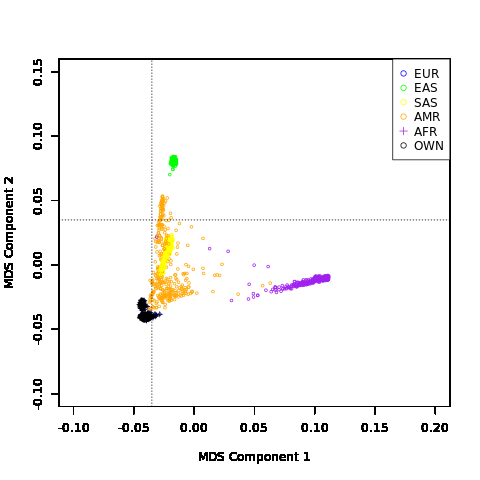

In [57]:
%%R
MDS_function("/mnt/data/GWAS/output/build38/task2.2_stratification/MDS_merge2.mds","/mnt/data/GWAS/output/task2.2_stratification/racefile.txt")

**The plot shows that our "own" data falls within the European group of the 1000 genomes data. Therefore, we do not have to remove subjects.**

Anyway we are running the filtering step for educational purposes.

### Filter out population stratification outliers

In [ ]:
%%bash
head $path/MDS_merge2.mds

In [ ]:
%%bash
# A commonly used thershold is taking 6 standad deviation from population mean as theshold for excluding individuals.
Rscript scripts/getFailures.R $path/MDS_merge2.mds $path/thresholds.txt $path/fail-pca-QC.txt


In [58]:
%%bash
# The cut-off levels are not fixed thresholds, so you can set them manually in the plot around your population of interest (uncomment next line for doing so).
awk '{ if ($4 <-0.02 && $5 < -0.02)  print $1,$2 }' $path/MDS_merge2.mds > $path/EUR_MDS_merge2 
wc -l $path/MDS_merge2.mds
wc -l $path/EUR_MDS_merge2

3000 /mnt/data/GWAS/output/build38/task2.2_stratification/MDS_merge2.mds
1062 /mnt/data/GWAS/output/build38/task2.2_stratification/EUR_MDS_merge2


In [59]:
%%bash
# Extract these individuals in the working dataset.
plink --bfile $path/../task2_QC/intermediate_datasets/dataset.b38.IBD --keep $path/EUR_MDS_merge2 --make-bed --out $intpath/dataset.b38.QCed

PLINK v1.90b3.45 64-bit (13 Jan 2017)      https://www.cog-genomics.org/plink2
(C) 2005-2017 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /mnt/data/GWAS/output/build38/task2.2_stratification/intermediate_datasets/dataset.b38.QCed.log.
Options in effect:
  --bfile /mnt/data/GWAS/output/build38/task2.2_stratification/../task2_QC/intermediate_datasets/dataset.b38.IBD
  --keep /mnt/data/GWAS/output/build38/task2.2_stratification/EUR_MDS_merge2
  --make-bed
  --out /mnt/data/GWAS/output/build38/task2.2_stratification/intermediate_datasets/dataset.b38.QCed

257659 MB RAM detected; reserving 128829 MB for main workspace.
316140 variants loaded from .bim file.
495 people (237 males, 258 females) loaded from .fam.
495 phenotype values loaded from .fam.
--keep: 495 people remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 495 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122

/mnt/data/GWAS/output/build38/task2.2_stratification/intermediate_datasets/dataset.b38.QCed.hh
); many commands treat these as missing.


In [64]:
%%bash
head /mnt/data/GWAS/output/build38/task2.2_stratification/intermediate_datasets/dataset.b38.QCed.fam

HGX00096 HGX00096 0 0 1 1
HGX00097 HGX00097 0 0 2 1
HGX00099 HGX00099 0 0 2 1
HGX00100 HGX00100 0 0 2 1
HGX00101 HGX00101 0 0 1 1
HGX00102 HGX00102 0 0 2 1
HGX00103 HGX00103 0 0 1 1
HGX00105 HGX00105 0 0 1 1
HGX00106 HGX00106 0 0 2 1
HGX00107 HGX00107 0 0 1 1


#### Create covariates based on MDS

In [60]:
%%bash
# Perform an MDS ONLY on HapMap data without ethnic outliers. The values of the 10 MDS dimensions are subsequently used as covariates in the association analysis in the third tutorial.
plink --bfile $intpath/dataset.b38.QCed --extract $path/../task2_QC/indepSNP.prune.in --genome --out $path/dataset.b38.QCed.genome
plink --bfile $intpath/dataset.b38.QCed --read-genome $path/dataset.b38.QCed.genome.genome --cluster --mds-plot 10 --out $path/dataset.b38.mds


PLINK v1.90b3.45 64-bit (13 Jan 2017)      https://www.cog-genomics.org/plink2
(C) 2005-2017 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /mnt/data/GWAS/output/build38/task2.2_stratification/dataset.b38.QCed.genome.log.
Options in effect:
  --bfile /mnt/data/GWAS/output/build38/task2.2_stratification/intermediate_datasets/dataset.b38.QCed
  --extract /mnt/data/GWAS/output/build38/task2.2_stratification/../task2_QC/indepSNP.prune.in
  --genome
  --out /mnt/data/GWAS/output/build38/task2.2_stratification/dataset.b38.QCed.genome

257659 MB RAM detected; reserving 128829 MB for main workspace.
316140 variants loaded from .bim file.
495 people (237 males, 258 females) loaded from .fam.
495 phenotype values loaded from .fam.
--extract: 232665 variants remaining.
Using up to 4 threads (change this with --threads).
Before main variant filters, 495 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323

/mnt/data/GWAS/output/build38/task2.2_stratification/dataset.b38.QCed.genome.hh
); many commands treat these as missing.
/mnt/data/GWAS/output/build38/task2.2_stratification/dataset.b38.mds.hh ); many
commands treat these as missing.


In [61]:
%%bash
head $path/dataset.b38.mds.mds
awk '{print$1, $2, $4, $5, $6, $7, $8, $9, $10, $11, $12, $13}' $path/dataset.b38.mds.mds > $path/covar_mds.txt
head $path/covar_mds.txt

       FID        IID    SOL           C1           C2           C3           C4           C5           C6           C7           C8           C9          C10 
  HGX00096   HGX00096      0 -0.000495704    0.0140154   -0.0111572   0.00363723  0.000969209  -0.00632788    0.0041895   -0.0226794    0.0104471    -0.014345 
  HGX00097   HGX00097      0 -2.64536e-05   0.00845106   -0.0159685   0.00652097   0.00261635 -0.000613264   -0.0104634   -0.0105515    0.0052152  -0.00294776 
  HGX00099   HGX00099      0 -0.000668454   0.00801473   -0.0200389   0.00786452 -0.000514026  -0.00662578  0.000594134    -0.017528  -0.00383219  -0.00608985 
  HGX00100   HGX00100      0   0.00473264    0.0161124    0.0111039     0.025022   0.00180064  -0.00509499    0.0305339   -0.0268026  -0.00699904    -0.019562 
  HGX00101   HGX00101      0 -0.000491384    0.0148019   -0.0151813    0.0112514   0.00721504  -0.00254442   0.00832269   -0.0173986   -0.0245312   -0.0155404 
  HGX00102   HGX00102      0  -0.0019588

In [63]:
%%bash
awk 'BEGIN {print "SEX","PHENO"};{print $5, $6}' $intpath/dataset.b38.QCed.fam > $intpath/temp
paste $path/covar_mds.txt $intpath/temp | sed 's/\t/ /g'> $path/covar_mds_sex_pheno.txt
rm $intpath/temp
head $path/covar_mds_sex_pheno.txt

FID IID C1 C2 C3 C4 C5 C6 C7 C8 C9 C10 SEX PHENO
HGX00096 HGX00096 -0.000495704 0.0140154 -0.0111572 0.00363723 0.000969209 -0.00632788 0.0041895 -0.0226794 0.0104471 -0.014345 1 1
HGX00097 HGX00097 -2.64536e-05 0.00845106 -0.0159685 0.00652097 0.00261635 -0.000613264 -0.0104634 -0.0105515 0.0052152 -0.00294776 2 1
HGX00099 HGX00099 -0.000668454 0.00801473 -0.0200389 0.00786452 -0.000514026 -0.00662578 0.000594134 -0.017528 -0.00383219 -0.00608985 2 1
HGX00100 HGX00100 0.00473264 0.0161124 0.0111039 0.025022 0.00180064 -0.00509499 0.0305339 -0.0268026 -0.00699904 -0.019562 2 1
HGX00101 HGX00101 -0.000491384 0.0148019 -0.0151813 0.0112514 0.00721504 -0.00254442 0.00832269 -0.0173986 -0.0245312 -0.0155404 1 1
HGX00102 HGX00102 -0.00195889 0.0138588 -0.0175688 0.00464131 0.00533101 -0.00363318 0.00562445 -0.0192282 -0.00802678 -0.0185233 2 1
HGX00103 HGX00103 0.000537389 0.0116175 -0.0118092 0.00174229 -0.00154448 -0.00206074 0.00584095 -0.00607365 0.0134285 -0.00544972 1 1
HGX00105 HGX00

**For the next step you need the following files:**
- dataset.b38.QCed (the bfile, i.e., dataset.b38.QCed.bed,dataset.b38.QCed.bim,and dataset.b38.QCed.fam)
- covar_mds.txt